# Mathematical Underpinnings - Lab 4

In [1]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, pearsonr
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import pandas as pd

In [2]:
np.random.seed(0)
sns.set_style("whitegrid")

## Task 1

### a)

#### bp 1)

In [3]:
# a heatmap
# you may use pcolormesh function and draw a heatmap for a sample
# or draw a heatmap for a teoretic density function

# I give you an answer to that task, because it may take too much time to do it during labs.

In [4]:
def plot_xyz(data_2d, nbins=300):
    x = data_2d[:, 0]
    y = data_2d[:, 1]
    k = gaussian_kde([x, y])
    xi, yi = np.mgrid[x.min() : x.max() : nbins * 1j, y.min() : y.max() : nbins * 1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    return xi, yi, zi

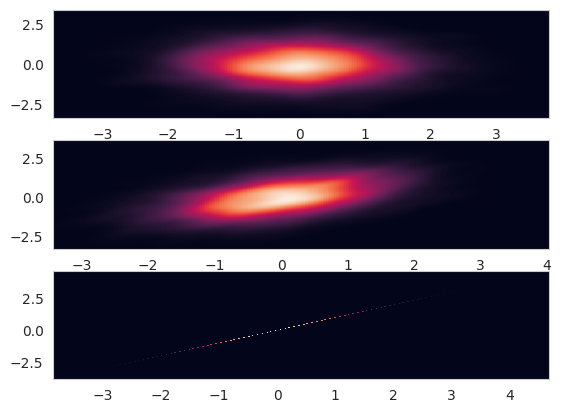

In [5]:
fig, axs = plt.subplots(3)

n_observations = 5000

data_2d = np.random.multivariate_normal(
    np.zeros(2), np.array([[1, 0], [0, 1]]), n_observations
)
xi_0, yi_0, zi_0 = plot_xyz(data_2d)
data_2d = np.random.multivariate_normal(
    np.zeros(2), np.array([[1, 0.5], [0.5, 1]]), n_observations
)
xi_1, yi_1, zi_1 = plot_xyz(data_2d)
data_2d = np.random.multivariate_normal(
    np.zeros(2), np.array([[1, 1], [1, 1]]), n_observations
)
xi_2, yi_2, zi_2 = plot_xyz(data_2d)

# Make the plot
axs[0].pcolormesh(xi_0, yi_0, zi_0.reshape(xi_0.shape), shading="auto")
axs[1].pcolormesh(xi_1, yi_1, zi_1.reshape(xi_1.shape), shading="auto")
axs[2].pcolormesh(xi_2, yi_2, zi_2.reshape(xi_2.shape), shading="auto")
plt.show()

#### bp 2)

In [6]:
# pearsonr - Pearson correlation
# mutual_info_classif - MI (I haven't checked if it works correctly, but it seems to;
#                           for sure sklearn.metrics.mutual_info_score doesn't do what we want)

In [7]:
def generate_sample_1(rho, n_observations):
    x, y = np.random.multivariate_normal(
        np.zeros(2), np.array([[1, rho], [rho, 1]]), n_observations
    ).T
    return x, y


def discretize_sample(x, n_bins):
    return np.digitize(x, np.linspace(x.min(), x.max(), n_bins))


def estimate_rho(x, y):
    return pearsonr(x, y).statistic


def estimate_mi(x, y):
    return mutual_info_classif(x.reshape(-1, 1), y, discrete_features=True)[0]


def estimate_dependence(x, y, n_bins=10):
    x = discretize_sample(x, n_bins)
    y = discretize_sample(y, n_bins)
    return estimate_rho(x, y), estimate_mi(x, y)

In [8]:
estimate_dependence(*generate_sample_1(0.5, 1000))

(0.470827045153915, 0.1541132124959666)

#### bp 3)

In [9]:
rho_sequence = np.linspace(0, 0.9, 10)
n_observations = 1000
n_repeats = 100

results_1 = []
for rho in rho_sequence:
    for repeat in range(n_repeats):
        rho_hat, mi_hat = estimate_dependence(*generate_sample_1(rho, n_observations))
        results_1.append(
            {
                "rho": rho,
                "repeat": repeat,
                "rho_hat": rho_hat,
                "mi_hat": mi_hat,
            }
        )
results_1 = pd.DataFrame(results_1)

results_1

,rho,repeat,rho_hat,mi_hat
0,0.0,0,0.042246,0.032908
1,0.0,1,0.010910,0.032725
2,0.0,2,0.070600,0.044825
3,0.0,3,-0.016437,0.026623
4,0.0,4,-0.014091,0.039560
...,...,...,...,...
995,0.9,95,0.872352,0.734382
996,0.9,96,0.867489,0.718341
997,0.9,97,0.857872,0.677153
998,0.9,98,0.875379,0.739622


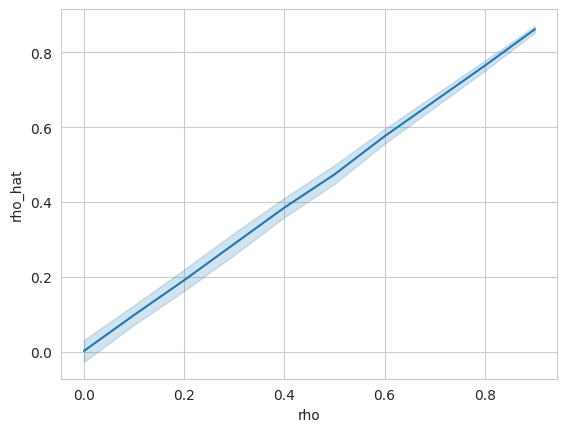

In [10]:
sns.lineplot(results_1, x="rho", y="rho_hat", errorbar="sd");

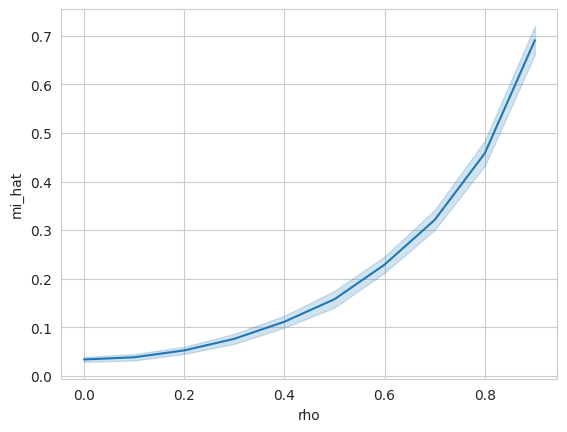

In [11]:
sns.lineplot(results_1, x="rho", y="mi_hat", errorbar="sd");

#### bp 4)

A hint: note that mutual information between two correlated normal distributions i.e. when $(X, Y)\sim \mathcal{N}((0,0)', \Sigma)$ and
$$\Sigma = \begin{pmatrix}
        \sigma_x^2 & \rho \\ \rho & \sigma_y^2
    \end{pmatrix}$$
equals
$$I(X,Y) = \frac{1}{2}\log \left(\frac{\sigma_x^2\sigma_y^2}{\sigma_x^2\sigma_y^2 - \rho^2}\right).$$

In [12]:
results_1["mi_1"] = -np.log(1 - results_1["rho"] ** 2) / 2
results_1["mi_2"] = -np.log(1 - results_1["rho_hat"] ** 2) / 2

results_1

,rho,repeat,rho_hat,mi_hat,mi_1,mi_2
0,0.0,0,0.042246,0.032908,-0.000000,0.000893
1,0.0,1,0.010910,0.032725,-0.000000,0.000060
2,0.0,2,0.070600,0.044825,-0.000000,0.002498
3,0.0,3,-0.016437,0.026623,-0.000000,0.000135
4,0.0,4,-0.014091,0.039560,-0.000000,0.000099
...,...,...,...,...,...,...
995,0.9,95,0.872352,0.734382,0.830366,0.715641
996,0.9,96,0.867489,0.718341,0.830366,0.698249
997,0.9,97,0.857872,0.677153,0.830366,0.665797
998,0.9,98,0.875379,0.739622,0.830366,0.726835


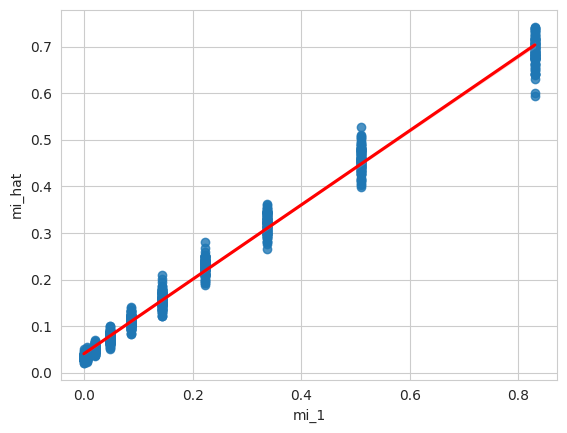

In [13]:
sns.regplot(results_1, x="mi_1", y="mi_hat", line_kws={"color": "red"});

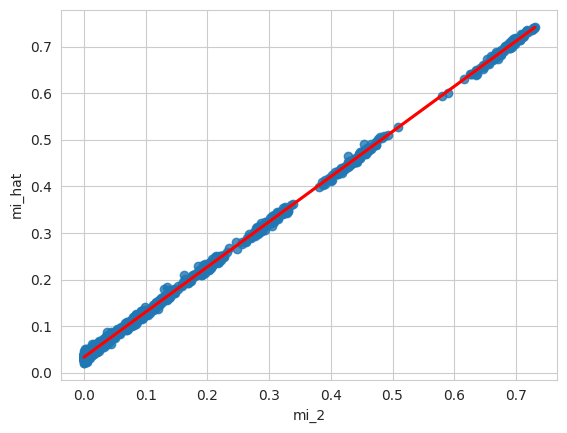

In [14]:
sns.regplot(results_1, x="mi_2", y="mi_hat", line_kws={"color": "red"});

As expected, the above plots resemble the identity relation.

### b)

#### bp 1)

In [15]:
# again: this is too time consuming so here is an answer

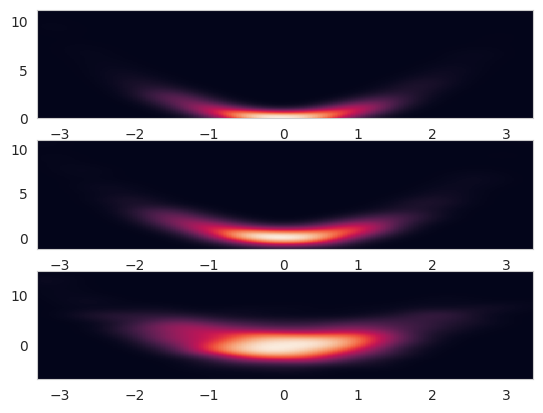

In [16]:
fig, axs = plt.subplots(3)

n_observations = 1000
x = np.random.normal(0, 1, n_observations)

data_2d = np.array([x, x**2 + np.random.normal(0, 0, n_observations)]).T
xi_0, yi_0, zi_0 = plot_xyz(data_2d)
data_2d = np.array([x, x**2 + np.random.normal(0, 0.5, n_observations)]).T
xi_1, yi_1, zi_1 = plot_xyz(data_2d)
data_2d = np.array([x, x**2 + np.random.normal(0, 2, n_observations)]).T
xi_2, yi_2, zi_2 = plot_xyz(data_2d)

# Make the plot
axs[0].pcolormesh(xi_0, yi_0, zi_0.reshape(xi_0.shape), shading="auto")
axs[1].pcolormesh(xi_1, yi_1, zi_1.reshape(xi_1.shape), shading="auto")
axs[2].pcolormesh(xi_2, yi_2, zi_2.reshape(xi_2.shape), shading="auto")
plt.show()

#### bp 2) and 3)

In [17]:
def generate_sample_2(sigma, n_observations):
    x = np.random.standard_normal(n_observations)
    y = x**2 + np.random.normal(0, sigma, n_observations)
    return x, y

In [18]:
estimate_dependence(*generate_sample_2(1, 1000))

(-0.0351845864276125, 0.33304001108454845)

In [19]:
sigma_sequence = np.linspace(0, 2, 21)
n_observations = 1000
n_repeats = 100

results_2 = []
for sigma in sigma_sequence:
    for repeat in range(n_repeats):
        rho_hat, mi_hat = estimate_dependence(*generate_sample_2(sigma, n_observations))
        results_2.append(
            {
                "sigma": sigma,
                "rep": repeat,
                "rho_hat": rho_hat,
                "mi_hat": mi_hat,
            }
        )
results_2 = pd.DataFrame(results_2)

results_2

,sigma,rep,rho_hat,mi_hat
0,0.0,0,-0.010907,0.626878
1,0.0,1,-0.038586,0.703573
2,0.0,2,-0.058833,0.661384
3,0.0,3,0.060360,0.644568
4,0.0,4,0.020363,0.606772
...,...,...,...,...
2095,2.0,95,0.012352,0.161207
2096,2.0,96,-0.031559,0.173020
2097,2.0,97,0.090531,0.187820
2098,2.0,98,-0.021144,0.154685


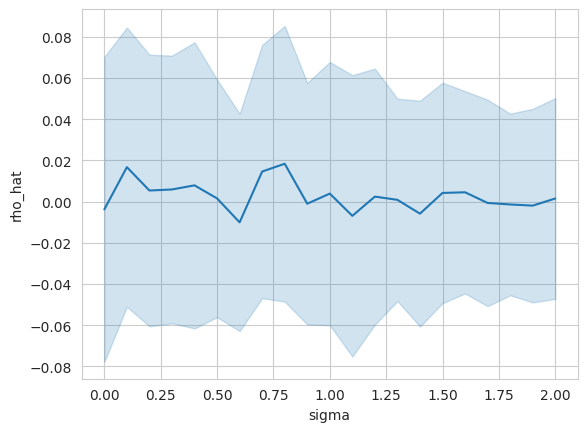

In [20]:
sns.lineplot(results_2, x="sigma", y="rho_hat", errorbar="sd");

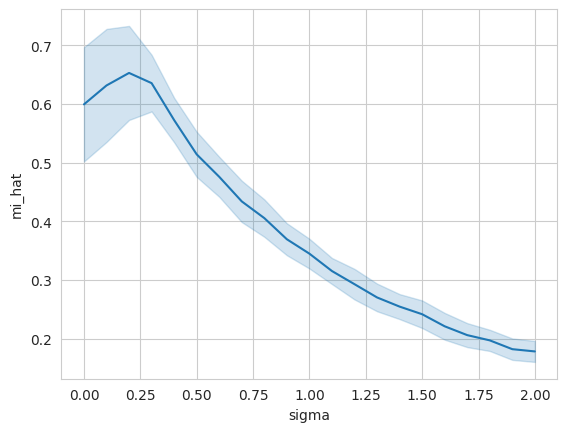

In [21]:
sns.lineplot(results_2, x="sigma", y="mi_hat", errorbar="sd");

## Task 2

### a)

In [22]:
from scipy.stats.contingency import crosstab


def asymptotic_independence_test(x, y, statistic, n_bins=10):
    assert len(x) == len(y)
    n_samples = len(x)

    x = discretize_sample(x, n_bins=n_bins)
    y = discretize_sample(y, n_bins=n_bins)

    assert statistic in ("mi", "chi2")
    if statistic == "mi":
        statistic_value = 2 * n_samples * estimate_mi(x, y)
    else:
        statistic_value = chi2_contingency(crosstab(x, y).count).statistic

    p_value = chi2.sf(statistic_value, (n_bins - 1) ** 2)

    return statistic_value, p_value

### b)

In [23]:
def permutation_independence_test(x, y, B, n_bins=10):
    assert len(x) == len(y)

    x = discretize_sample(x, n_bins=n_bins)
    y = discretize_sample(y, n_bins=n_bins)

    statistic_value = estimate_mi(x, y)

    p_value = 1
    for _ in range(B):
        p_value += int(estimate_mi(np.random.permutation(x), y) >= statistic_value)
    p_value /= 1 + B

    return statistic_value, p_value

### c)

**Independent r.v.**

A hint: two discretized independent normal random variables (or any two independent discrete r.v.)

In [24]:
# independent r.v. - we expect that our tests don't reject the null hypothesis

In [25]:
rho = 0
n_observations = 5000

x, y = generate_sample_1(rho, n_observations)

In [26]:
asymptotic_independence_test(x, y, "mi")

(68.35141961043323, 0.8407784290136096)

In [27]:
asymptotic_independence_test(x, y, "chi2")

(76.86204686402507, 0.6095630985846958)

In [28]:
permutation_independence_test(x, y, 100)

(0.0068351419610433225, 0.45544554455445546)

All tests correctly do not reject the null hypothesis (assuming significance level of 0.01).

**Dependent r.v.**

A hint: two discretized dependent normal random variables (or two categorical wuch that we enforce $X=Y$ for a subset of observations)

In [29]:
# dependent r.v. - ideally we will reject the null hypothesis

In [30]:
rho = 0.5
n_observations = 5000

x, y = generate_sample_1(rho, n_observations)

In [31]:
asymptotic_independence_test(x, y, "mi")

(1262.5866096267766, 2.2944964866255395e-211)

In [32]:
asymptotic_independence_test(x, y, "chi2")

(1503.3960932384325, 1.1469710035585057e-260)

In [33]:
permutation_independence_test(x, y, 100)

(0.12625866096267765, 0.009900990099009901)

All tests correctly reject the null hypothesis (assuming significance level of 0.01).